BUDT 737\
Fall 2021\
Final Project\
 

# Pandemic Tweet Challenge

Introduction: \

Social media has become the main source of communication and a method of extracting public opinions and certain topics related to the nature of the dataset. The problem we are trying to solve is deriving meaningful insight into public opinion regarding largely controversial issues. This dataset is regarding COVID-19 and is a controversial topic on different levels whether lockdowns are placed in action, vaccines, or mask mandates. It is difficult to analyze these opinions on a surface level. Building a model that gives insight into the source of controversy in these public opinions gives public officials the ability to speak to them with greater understanding on the topic, demographics, segments, and trends.\
\
Sentiment analysis is a widely used method currently used to find accuracy of the application being used. Although widely used it faces challenges such as polarity, sarcasm, comparative sentences, emojis; our goal is to create a model which can learn from these issues and improve as the model is trained. We plan to use the LSTM model and Fully Connected Feedforward model because both allow for a training component to sentiment analysis for the different tweets. Both models implement the technique known as gradient descent over random forest and gradient boosting leading to successful predictions and higher accuracies.


In [ ]:
# Import Libraries
import numpy as np
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read data from csv file
df = pd.read_csv('/content/drive/MyDrive/737project/BUDT737 Files/Pandemic_NLP_train1.csv', encoding='iso-8859-1')
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


Data: \

The data is a collection of thousands of tweets related to the coronavirus with corresponding sentiments, which is divided into training and testing data. We got our data from Kaggle. There are five categories for the sentiment of tweets, Neutral, Positive, Negative, Extremely Positive and Extremely Negative. From the visualization we can see that there are around 8000 neutral, 12000 Positive, 5900 Extremely Negative, 10000 Negative, and 7000 Extremely Positive tweet sentiments. \

The tweets contain three different elements: text, @, and #. The text in tweets are the main object to be analyzed for the project, as a result, we need to clean the data to remove @ and # content to get the text for sentiment analysis.


In [ ]:
# Take only Tweet and sentiment from the original data set
data=df[['OriginalTweet','Sentiment']]
# Convert sentiment into catogories labels
sent= {'Extremely Positive':4,'Positive':3,'Neutral':2, 'Negative':1, 'Extremely Negative':0} 
data['labels']=data['Sentiment'].map(sent)
# Covert the text to lower case
data['text'] = data['OriginalTweet'].apply(lambda x: x.lower()) 
# Remove website
data['text'] = data['text'].apply((lambda x: re.sub('http\S+', '',x)))
# Remove @
data['text'] = data['text'].apply((lambda x: re.sub('@\S+', '',x)))
#  Remove non-text
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z\s]','',x)))
data.head(10)

,OriginalTweet,Sentiment,labels,text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,2,and and
1,advice Talk to your neighbours family to excha...,Positive,3,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,3,coronavirus australia woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,3,my food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,me ready to go at supermarket during the covid...
5,As news of the regionÂs first confirmed COVID...,Positive,3,as news of the regions first confirmed covid c...
6,Cashier at grocery store was sharing his insig...,Positive,3,cashier at grocery store was sharing his insig...
7,Was at the supermarket today. Didn't buy toile...,Neutral,2,was at the supermarket today didnt buy toilet ...
8,Due to COVID-19 our retail store and classroom...,Positive,3,due to covid our retail store and classroom in...
9,"For corona prevention,we should stop to buy th...",Negative,1,for corona preventionwe should stop to buy thi...


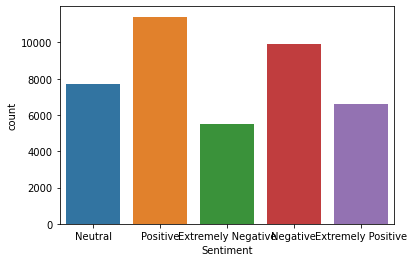

In [ ]:
data.shape
import seaborn as sns
sns.countplot(x='Sentiment', data=data)

Describe some existing methods: \

1. Sentiment analysis can include unsupervised or supervised techniques. Unsupervised techniques are still existing methods used such as corpus of words associated with polarity and sentiment involved. Polarities play a role in this technique and the category is assigned based on the polarity.
2. Topic modeling is an NLP method which analyses topics in text. The documents that are present here are the tweets and amongst the COVID-19 there can be topics derived such as vaccine, quarantine, and mask mandates. The tweets are “documents” that include various topics; these topics can include multiple words that would be associated with the topic. This is valuable however using methods such as tokenization and tf-idf allow for the importance of words that could be in topics through the vector representation. Bi-grams and further can also pick up the importance of surrounding words and context.
3. WordCloud is a method of visual representation of various words in which greater prominence is given to words of higher frequency relative to others. Documents that are in the COVID-19 tweets can be analyzed for the most frequently occurring words. After filtering out common words, the importance of words can be determined through frequency because they are being represented a lot in the documents because it’s the topic rather than a common word in the language.
4. KNN classification of Word2Vec is another method which is used for popular representation of words by capturing the linguistic context of them. The algorithm leverages machine learning to determine word associations from a large corpus. This has application to COVID-19 tweets as we can understand the context behind popular words to get greater insight than what frequency can provide alone. Average accuracy 53.0% for tweet sentiment which is 4.02% less than the fully connected feedforward network and 21.90% less accurate than the LSTM model we created.


# Fully Connected Feedforward Network

Fully connected feedforward network: We apply the tf-idf on the text to receive the vector representation of the top 2000 features or sequences. \
a. Tf-idf: We used this method to create the vectorization and transformation of sequences. \
b. First input layer has 3000 neurons with the input dimensionality of the 2000 max features with the activation function ‘relu’.\
c. Fully connected layer with dropout rate - 0.2 \
d. Second layer has 2000 neurons; activation function ‘relu’. \
e. Fully connected layer with dropout rate - 0.2 \
f. Output layer has 5 neurons for the 5 class classification of sentiment leading to the use of softmax. After this we compile the network using categorical crossentropy as the loss function.


In [ ]:
# Split training and testing data and make labels into dummy variables
df_train=data[:int(len(data)*0.7)]
df_validation=data[int(len(data)*0.7):]
training_texts=df_train.text.values
traing_labels=pd.get_dummies(df_train['labels']).values 
validation_texts=df_validation.text.values
validation_labels=pd.get_dummies(df_validation['labels']).values 

In [ ]:
# Apply tf-idf on the text
vectorizer= TfidfVectorizer(stop_words='english',max_features=2000,ngram_range=(1,3))
docs=list(training_texts)+list(validation_texts)
instances=vectorizer.fit_transform(docs)
x_train = np.asarray(instances.todense())[:len(training_texts)]
x_test = np.asarray(instances.todense())[len(training_texts):]
y_train = traing_labels.astype(float)
y_test= validation_labels.astype(float)

print(x_train[:3])
print(vectorizer.get_feature_names()[:30])
print(x_train.shape)
len(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['able', 'absolute', 'absolutely', 'access', 'according', 'account', 'act', 'action', 'actions', 'activity', 'actual', 'actually', 'adapt', 'add', 'added', 'additional', 'address', 'advantage', 'advertising', 'advice', 'affairs', 'affect', 'affected', 'affected covid', 'affecting', 'afford', 'affordable', 'africa', 'ag', 'age']
(28809, 2000)


28809

In [ ]:
# Construct fully connected feedforward  network
model1 = Sequential()
model1.add(Dense(3000, input_dim = 2000, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(2000, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(5,activation='softmax'))
# Compile the model by setting loss, optimizer and metrics
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3000)              6003000   
                                                                 
 dropout (Dropout)           (None, 3000)              0         
                                                                 
 dense_1 (Dense)             (None, 2000)              6002000   
                                                                 
 dropout_1 (Dropout)         (None, 2000)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 10005     
                                                                 
Total params: 12,015,005
Trainable params: 12,015,005
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Train the model with training data
model1.fit(x_train,y_train, epochs = 5, batch_size = 100)

Epoch 1/5
289/289 [==============================] - 73s 246ms/step - loss: 1.1868 - accuracy: 0.5021
Epoch 2/5
289/289 [==============================] - 79s 274ms/step - loss: 0.8555 - accuracy: 0.6726
Epoch 3/5
289/289 [==============================] - 66s 228ms/step - loss: 0.4426 - accuracy: 0.8470
Epoch 4/5
289/289 [==============================] - 60s 207ms/step - loss: 0.1307 - accuracy: 0.9635
Epoch 5/5
289/289 [==============================] - 61s 213ms/step - loss: 0.0698 - accuracy: 0.9828


In [ ]:
# Test the model with testing data and print out accuracy
scores=model1.evaluate(x_test,y_test)
print("\n%s:%.2f%%"%(model1.metrics_names[1],scores[1]*100))

386/386 [==============================] - 10s 25ms/step - loss: 1.8470 - accuracy: 0.5702

accuracy:57.02%


We received an accuracy of 57.02%. There is some overfitting which leads to the reasoning of using the LSTM model below.

# LSTM

LSTM: We define the number of max features as 10000 and use a tokenizer to vectorize and to convert the text into sequences so the network can deal with it. Then we create the sequential model and add layers to compose the LSTM network. The layers are as follows: \
a. An embedding layer that converts word tokens into embedding of specific size, in our project we add an embedding layer with input dimensionality of 10000, and output dimensionality of 128 \
b. An dropout layer with the spacial dropout rate of 0.4, which dropping entire sentence in batch \
c. We then add the LSTM layer, which defined by hidden state dims and number of layers, with dropout for input and neurons in hidden layers of dropout rate of 0.2 \
d. We also add fully connected layers with 0.2 dropout rate, and by using softmax as the activation function. After this we compile the network using categorical crossentropy as the loss function.


In [ ]:
# set the tokenizer number of words to 10000, and spliting words by space
max_fatures = 10000
tokenizer = Tokenizer(num_words=max_fatures, split=' ') 
# apply the tokenizer to text to get word index appear in all the text
tokenizer.fit_on_texts(data['text'].values) 
# convert each text into a list of integer based on the index created
X = tokenizer.texts_to_sequences(data['text'].values) 
# make all index into same length by filling in 0
X = pad_sequences(X)

In [ ]:
# In this part, we build the neuron network model by adding LSTM layer and fully connected layer #

embed_dim = 128
lstm_out = 196
 
model2 = Sequential() 
# add a Aembedding layer with input dimensionality of 10000, and output dimensionality of 128
model2.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1])) 
# add a dropout layer with the spacial dropout rate of 0.4, droping entire scentence in batch
model2.add(SpatialDropout1D(0.4)) 
# add a LSTM layer with dropout for input and neurons in hidden layers of dropout rate of 0.2
model2.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
# add a fully connected layer with 0.2 dropout rate
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.2))
# add a fully connected layer by using softmax as the activation function
model2.add(Dense(5,activation='softmax'))
# compile the network using categorical crossentropy as the loss, due to two output categories
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy']) 

print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 61, 128)           1280000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 61, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense_3 (Dense)             (None, 100)               19700     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 505       
                                                      

In [ ]:
Y = pd.get_dummies(data['labels']).values 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42) 

In [ ]:
batch_size = 32
model2.fit(X_train, Y_train, epochs = 5, batch_size=batch_size)

Epoch 1/5
901/901 [==============================] - 346s 383ms/step - loss: 0.3570 - accuracy: 0.8759
Epoch 2/5
901/901 [==============================] - 344s 382ms/step - loss: 0.3059 - accuracy: 0.8961
Epoch 3/5
901/901 [==============================] - 362s 401ms/step - loss: 0.2659 - accuracy: 0.9100
Epoch 4/5
901/901 [==============================] - 335s 372ms/step - loss: 0.2346 - accuracy: 0.9187
Epoch 5/5
901/901 [==============================] - 330s 366ms/step - loss: 0.2110 - accuracy: 0.9263


In [ ]:
scores=model2.evaluate(X_test,Y_test)
print("\n%s:%.2f%%"%(model2.metrics_names[1],scores[1]*100))

386/386 [==============================] - 22s 58ms/step - loss: 0.9269 - accuracy: 0.7638

accuracy:76.38%


Then the dataset is split into training and testing sets and we run the model. We received accuracy around 76.38%

In [ ]:
## test the model using a sample tweet ##

twt = pd.DataFrame(["with 100  nations inficted with  covid  19  the world must  not  play fair with china  100 goverments must demand  china  adopts new guilde  lines on food safty  the  chinese  goverment  is guilty of  being  irosponcible   with life  on a global scale"])
twt[0] = twt[0].apply(lambda x: x.lower()) 
twt[0] = twt[0].apply((lambda x: re.sub('http\S+', '',x)))
twt[0] = twt[0].apply((lambda x: re.sub('@\S+', '',x)))
twt[0] = twt[0].apply((lambda x: re.sub('[^a-zA-z\s]','',x)))

# convert the text into a list of integer based on the index of words created
twt = tokenizer.texts_to_sequences(twt[0]) 
# make the list into same length by filling in 0
twt = pad_sequences(twt, maxlen=62, dtype='int32', value=0) 
print(twt)
# use the model to predict the sentiment of the 
sentiment = model2.predict(twt,batch_size=1,verbose = 2)[0] 
print(np.argmax(sentiment))
if(np.argmax(sentiment) == 0):
    print("Extremely Negative")
elif (np.argmax(sentiment) == 1):
    print("Negative")
elif (np.argmax(sentiment) == 2):
    print("Neutral")
elif (np.argmax(sentiment) == 3):
    print("Positive")
elif (np.argmax(sentiment) == 4):
    print("Extremely Positive")



[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0   22 1746   22    6    1  169  275   35 1222 1208   22
   295  275   77  295   91  485   13   19    1  760   11 4348    5  122
    22  288   13    7  204 2839]]
1/1 - 0s - 63ms/epoch - 63ms/step
0
Extremely Negative


Results: \

A 2-class sentiment generally will have an 80 % accuracy rate. We do not have an exact baseline for a 5-class sentiment analysis, however we can compare the result to the 2-class sentiment analysis, since it is more difficult to have a higher level classification of sentiment. \

In our project, the fully connected feedforward network gets a 57% accuracy and the LSTM model reaches a 76% accuracy in reaching. The fully connected feedforward network uses tf-idf as the input to analyze importance for each word but not consider the sequence and content of the tweet. This will result in an overfitting issue of having a high accuracy in training data but low accuracy in testing due to same word used but different content and meaning in sentences. \

The LSTM model gets a 76% accuracy in categorizing 5-class sentiment. By taking word location in sentences, and also considering their order, the full meaning of the sentence and also the level of positive and negative can be analyzed in the model. Since the project is a 5-class sentiment analysis, LSTM seems to be the better choice to complete this task and get a higher accuracy.
